# ChArUco

- ref: https://github.com/kyle-bersani/opencv-examples
- don't use digital smoothing!

```
$ cd /path/to/raw/
$ # /path/to/raw/{_back.mp4, _main.mp4 (both record 3D format)}
$ ffmpeg -i _back.mp4 -vf "crop=w=1440:h=1920:x=1440:y=0, transpose=2" back.mp4
$ ffmpeg -i _main.mp4 -vf "crop=w=1440:h=1920:x=1440:y=0, transpose=2" main.mp4
$ ffmpeg -i main.mp4 -map 0 -c copy -f segment -segment_time 60 -reset_timestamps 1 main_%03d.mp4
$ cd /path/to/aruco
$ rm -rf charuco camera_*.pkl
$ python get_intrinsics.py --vid /path/to/raw/back.mp4 --squares 5 7
$ python get_nerf_dataset.py --vid ../data/record3d/tonpy-$v/raw/back.mp4
mv charuco ../data/record3d/tonpy-$v/
./nerfstudio_train.sh $v
```

In [17]:
import cv2
import cv2.aruco as aruco
import imageio
import numpy as np
import matplotlib.pyplot as plt
import imageio
from copy import deepcopy
from tqdm import tqdm
import pickle

from utils import undistort


aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_1000)
charuco = aruco.CharucoBoard_create(
        squaresX=10,
        squaresY=7,
        squareLength=0.039,
        markerLength=0.0195,
        dictionary=aruco_dict)

In [18]:
with open('camera_raw.pkl', 'rb') as f:
    (mtx, dist) = pickle.load(f)

vid = imageio.mimread("../data/record3d/tonpy-v8/raw/main_000.mp4", memtest=False)
vid = undistort(vid, mtx, dist)

with open('camera_undist.pkl', 'rb') as f:
    (mtx, dist) = pickle.load(f)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2001/2001 [00:44<00:00, 44.84it/s]


In [19]:
vid_sample, vid_paint, rvec_hist, tvec_hist = [], [], [], []

for t, img in enumerate(vid[30:-30:3]):
    bak = deepcopy(img)
    img = deepcopy(img[...,::-1])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    aruco_params = aruco.DetectorParameters_create()
    corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=aruco_params)

    corners, ids, rejectedImgPoints, recoveredIds = aruco.refineDetectedMarkers(
            image = gray,
            board = charuco,
            detectedCorners = corners,
            detectedIds = ids,
            rejectedCorners = rejectedImgPoints,
            cameraMatrix = mtx,
            distCoeffs = dist)

    img = aruco.drawDetectedMarkers(img, corners, borderColor=(0, 0, 255), ids=ids)

    if not (ids is not None and len(ids) > 1):
        print("skip (t={}, ids={})".format(t, ids))
        continue

    response, charuco_corners, charuco_ids = aruco.interpolateCornersCharuco(
            markerCorners=corners,
            markerIds=ids,
            image=gray,
            board=charuco)

    if response < 8:
        print("skip (t={}, response={})".format(t, response))
        continue

    # valid, rvec, tvec = aruco.estimatePoseCharucoBoard(
    #         charucoCorners=charuco_corners,
    #         charucoIds=charuco_ids,
    #         board=charuco, 
    #         cameraMatrix=mtx,
    #         distCoeffs=dist,
    #         rvec=None,
    #         tvec=None)
    
    objp = np.empty((0,3), np.float32)
    for idx in charuco_ids:
        objpi = np.dot(charuco.chessboardCorners[idx] - np.array([[5,7,0]]) * 0.04, np.array([[-1,0,0], [0,1,0], [0,0,-1]]))
        objp = np.append(objp, objpi, axis=0)

    valid, rvec, tvec = cv2.solvePnP(objp, charuco_corners, mtx, dist)

    if not valid:
        print("skip (t={}, valid={})".format(t, valid))
        continue

    img = cv2.drawFrameAxes(img, mtx, dist, rvec, tvec, 0.3)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    vid_sample.append(bak)
    vid_paint.append(img)
    rvec_hist.append(rvec)
    tvec_hist.append(tvec)

print(len(vid_sample))
imageio.mimwrite("temp.mp4", vid_paint, macro_block_size=8)

skip (t=131, response=7)
skip (t=134, response=7)
skip (t=135, response=5)
skip (t=136, response=4)
skip (t=139, response=4)
skip (t=140, response=7)
skip (t=141, response=3)
skip (t=142, response=7)
skip (t=144, response=7)
skip (t=145, response=6)
skip (t=146, response=7)
skip (t=147, response=4)
skip (t=148, response=1)
skip (t=149, response=0)
skip (t=150, response=3)
skip (t=151, response=0)
skip (t=152, response=1)
skip (t=153, response=0)
skip (t=154, response=0)
skip (t=155, response=0)
skip (t=156, response=1)
skip (t=157, response=1)
skip (t=158, response=2)
skip (t=159, response=0)
skip (t=160, response=0)
skip (t=161, response=3)
skip (t=162, response=2)
skip (t=163, response=2)
skip (t=164, response=2)
skip (t=165, response=5)
skip (t=166, response=5)
skip (t=168, response=7)
skip (t=172, response=6)
skip (t=174, response=7)
skip (t=175, response=7)
skip (t=324, response=4)
skip (t=325, response=0)
skip (t=326, ids=[[5]])
skip (t=327, response=0)
skip (t=330, response=7)
s

In [21]:
with open('poses.pkl', 'wb') as f:
    pickle.dump((rvec_hist, tvec_hist), f)

In [85]:
imageio.mimwrite("src/main_real.mp4", vid_sample, macro_block_size=8)

In [86]:
w = 1920
h = 1440  # 1080

import os
import PIL
import json
import torch

# os.makedirs('images/', exist_ok=True)

out = {
    "fl_x": float(mtx[0,0]),
    "fl_y": float(mtx[1,1]),
    "cx": float(mtx[0,2]),
    "cy": float(mtx[1,2]),
    "w": w,
    "h": h,
    "camera_model": 'OPENCV',
    "k1": dist[0,0],
    "k2": dist[0,1],
    "p1": dist[0,2],
    "p2": dist[0,3],
}

poses = []
for t, (rvec, tvec) in enumerate(zip(rvec_hist, tvec_hist)):
    R, _ = cv2.Rodrigues(rvec)
    T = tvec

    c2w = np.eye(4)
    c2w[:3,3] = np.dot(R.T, - T).squeeze()
    c2w[:3,:3] = np.dot(R.T, np.array([[1,0,0], [0,-1,0], [0,0,-1]]))
    poses.append(c2w)


poses = torch.from_numpy(np.array(poses).astype(np.float32))
print(torch.max(torch.abs(poses[:, :3, 3])))


tensor(0.8383)


In [87]:
# scale_factor = 1.0
# scale_factor /= torch.max(torch.abs(poses[:, :3, 3]))
# print(scale_factor)
# poses[:, :3, 3] *= scale_factor * self.config.scale_factor

In [88]:
frames = []

for t, (img, c2w) in enumerate(zip(vid_sample, poses)):
    name = 'images/frame_{:05}.png'.format(t)
    # PIL.Image.fromarray(img).save(name, quality=95)  # heavy

    frame = {
        "file_path": name,
        "transform_matrix": c2w.tolist(),
    }
    frames.append(frame)

out["frames"] = frames

with open("transforms.json", "w", encoding="utf-8") as f:
    json.dump(out, f, indent=4)

In [ ]:
len(frames)

In [1]:
import cv2
import cv2.aruco as aruco
import imageio
import numpy as np
import matplotlib.pyplot as plt
import imageio
from copy import deepcopy
from tqdm.notebook import tqdm
import pickle
from utils import *

main_real = imageio.mimread("temp/main_real_000.mp4", memtest=False)
main_pred = imageio.mimread("temp/main_pred_000.mp4", memtest=False)
print(len(main_real), main_real[0].shape, len(main_pred), main_pred[0].shape)

623 (1440, 1920, 3) 623 (720, 960, 3)


In [16]:
size = (960, 720)
idx = 0

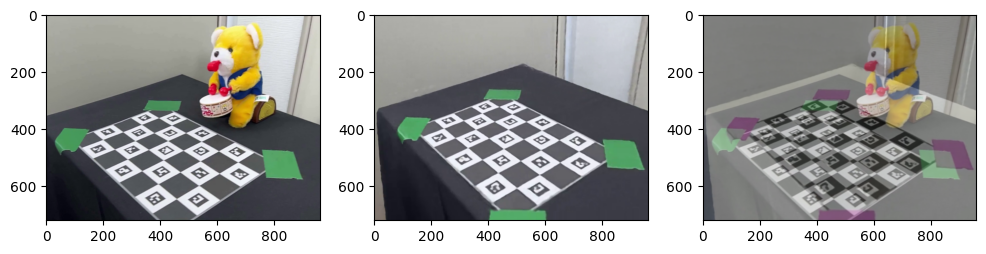

In [3]:
real = deepcopy(main_real[idx])
pred = deepcopy(main_pred[idx])
real = cv2.resize(real, size)
pred = cv2.resize(pred, size)

plt.figure(figsize=(12,12))
plt.subplot(1,3,1); plt.imshow(real)
plt.subplot(1,3,2); plt.imshow(pred)

real = cv2.blur(real, (3,3))
pred = cv2.blur(pred, (3,3))
diff = real.astype(np.float32) - pred.astype(np.float32)
diff = (diff / 255. + 1.) / 2.

plt.subplot(1,3,3); plt.imshow(diff)
plt.show()

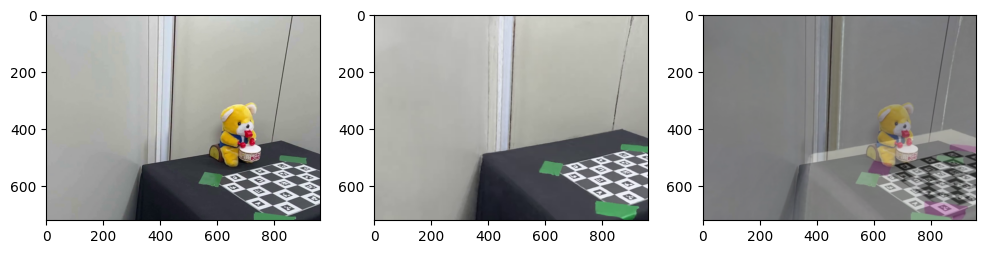

In [17]:
idx = 0
real = deepcopy(main_real[idx])
pred = deepcopy(main_pred[idx])
real = cv2.resize(real, size)
pred = cv2.resize(pred, size)

plt.figure(figsize=(12,12))
plt.subplot(1,3,1); plt.imshow(real)
plt.subplot(1,3,2); plt.imshow(pred)

real = cv2.blur(real, (3,3))
pred = cv2.blur(pred, (3,3))
diff = real.astype(np.float32) - pred.astype(np.float32)
diff = (diff / 255. + 1.) / 2.

plt.subplot(1,3,3); plt.imshow(diff)
plt.show()

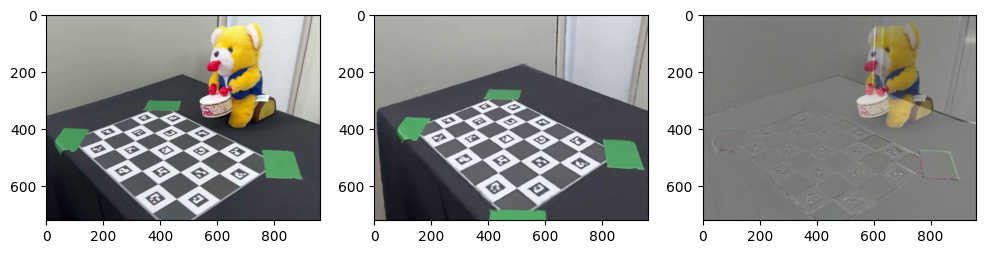

In [4]:
warper = Warper()

real = deepcopy(main_real[idx])
pred = deepcopy(main_pred[idx])
real = cv2.resize(real, size)
pred = cv2.resize(pred, size)

plt.figure(figsize=(12,12))
plt.subplot(1,3,1); plt.imshow(real)
plt.subplot(1,3,2); plt.imshow(pred)

real = cv2.blur(real, (3,3))
pred = cv2.blur(pred, (3,3))

pred = warper(pred, real)[1]

diff = real.astype(np.float32) - pred.astype(np.float32)
diff = (diff / 255. + 1.) / 2.

plt.subplot(1,3,3); plt.imshow(diff)
plt.show()

0.7372549 [0.3882353]


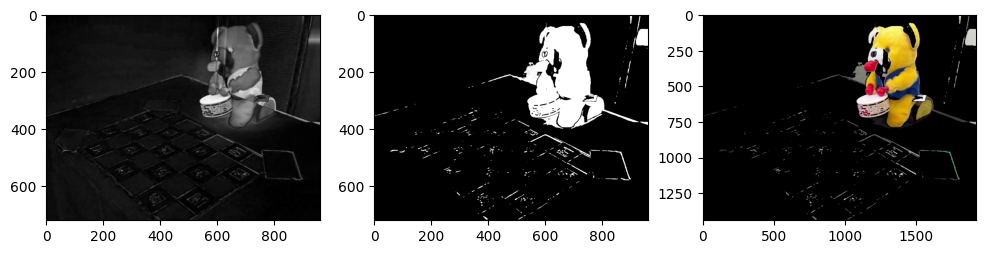

In [5]:
real = deepcopy(main_real[idx])
pred = deepcopy(main_pred[idx])

real = cv2.resize(real, size)
pred = cv2.resize(pred, size)
real = cv2.blur(real, (3,3))
pred = cv2.blur(pred, (3,3))
pred = warper(pred, real)[1]

plt.figure(figsize=(12,12))

diff_rgb = real.astype(np.float32) - pred.astype(np.float32)
diff_rgb = np.mean(np.abs(diff_rgb), axis=2) / 255.
plt.subplot(1,3,1); plt.imshow(diff_rgb, cmap='gray')

print(diff_rgb.max(), np.percentile(diff_rgb, [98]))
thresh = 0.15  # threshより明るい => 問答無用で1
diff_rgb = np.clip(diff_rgb, 0, thresh) / thresh

diff_rgb = np.where(diff_rgb < 0.9, 0, diff_rgb)
plt.subplot(1,3,2); plt.imshow(diff_rgb, cmap='gray')

out = deepcopy(main_real[idx])/ 255.
diff_rgb = (diff_rgb.astype(np.float32) * 255).astype(np.uint8)
diff_rgb = cv2.resize(diff_rgb, out.shape[0:2][::-1])
out = out.astype(np.float32) * diff_rgb.astype(np.float32)[...,None] / 255.
plt.subplot(1,3,3); plt.imshow(out)
plt.show()

In [1]:
import cv2
import cv2.aruco as aruco
import imageio
import numpy as np
import matplotlib.pyplot as plt
import imageio
from copy import deepcopy
import pickle
from utils import *
from tqdm.notebook import tqdm

main_real = imageio.mimread("temp/main_real_000.mp4", memtest=False)
main_pred = imageio.mimread("temp/main_pred_000.mp4", memtest=False)
print(len(main_real), main_real[0].shape, len(main_pred), main_pred[0].shape)

662 (1440, 1920, 3) 662 (360, 480, 3)


In [2]:
with open('camera_undist.pkl', 'rb') as f:
    (mtx, dist) = pickle.load(f)
with open('temp/poses_000.pkl', 'rb') as f:
    (indices, rvec_hist, tvec_hist) = pickle.load(f)
print(len(rvec_hist), len(tvec_hist))

662 662


In [3]:
warper = Warper()
remover = BackRemover()
cropper = Cropper()

  0%|          | 0/21 [00:00<?, ?it/s]

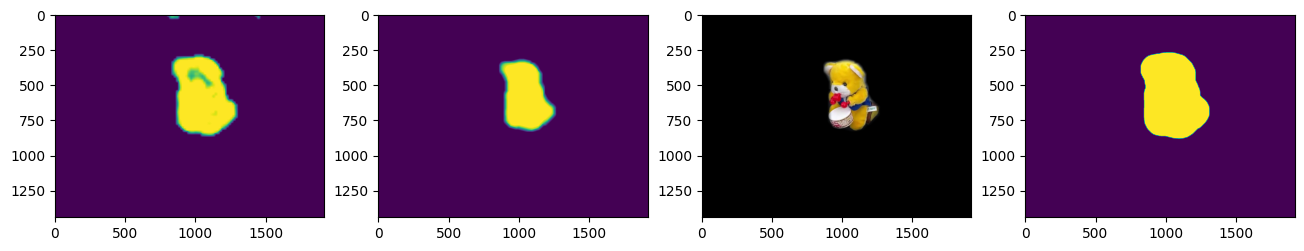

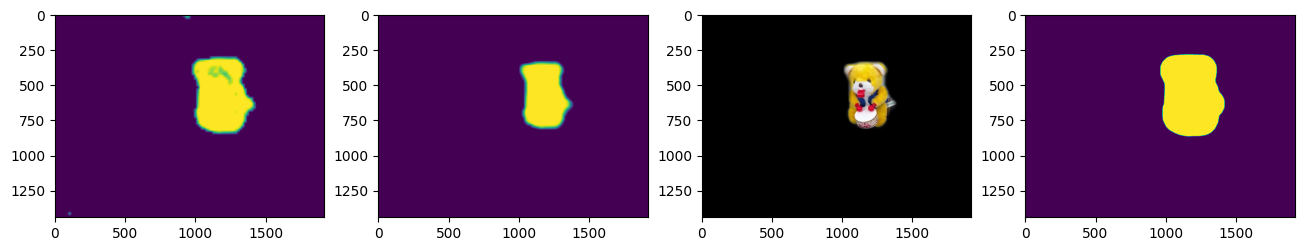

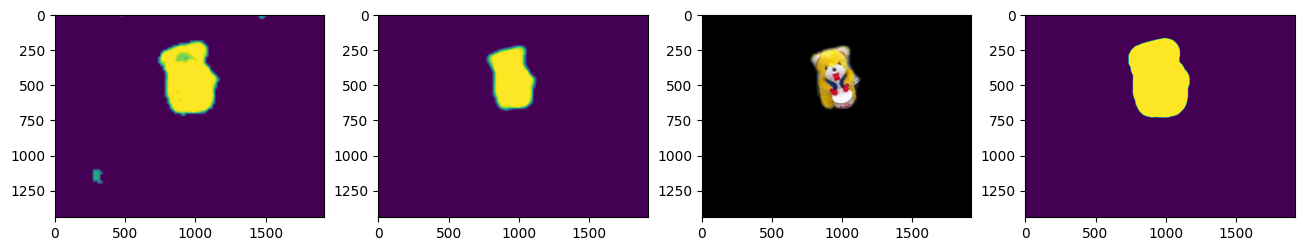

bad_indices: []


In [8]:
frames = []
bad_indices = []
size = 512
scale = 1.
sl = 0.04
index_prev = None
st, gt = 70, 91

for t, (index, real, pred, rvec, tvec) in enumerate(
    zip(tqdm(indices[st:gt]), main_real[st:gt], main_pred[st:gt], rvec_hist[st:gt], tvec_hist[st:gt])):

    real_orig = deepcopy(real)
    pred_orig = deepcopy(pred)
    real = deepcopy(real)
    pred = deepcopy(pred)

    R, _ = cv2.Rodrigues(rvec)
    T = tvec

    wpos_target = np.float32([[0,0,0.065]])
    cpos_target = project_w2c(wpos_target, rvec, tvec, mtx, dist).astype(np.int16)

    wpos_board = np.float32([[3.5,-2,0], [3.5,-7,0], [-3.5,-7,0], [-3.5,-2,0]]) * sl
    cpos_board = project_w2c(wpos_board, rvec, tvec, mtx, dist).astype(np.int32)

    wpos_camera = np.dot(R.T, - T).squeeze()
    wrot_camera = cv2.RQDecomp3x3(R.T)[0]
    _scale = np.sum(wpos_camera**2)**0.5 * scale
    
    if index_prev == index - 1:
        mask_aux = mask_aux
    else:
        mask_aux = None

    if not real.shape == pred.shape:        
        pred = cv2.resize(pred, real.shape[-2:-4:-1])

    ret, *out = warper(pred, real)
    if ret:
        pred, = out

        ret, *out = remover(real, pred, cpos_board, cpos_target, mask_aux)    
        if ret:
            segm, mask_aux, diff, alpha = out

    if not ret:
        msg, = out
        bad_indices.append(index)
        print("skip (t={}, msg=\"{}\")".format(t, msg))

        # first failure in last some frames
        if index_prev == index - 1:
            plt.figure(figsize=(8,8))
            plt.subplot(1,2,1); plt.imshow(real_orig); plt.subplot(1,2,2); plt.imshow(pred_orig)
            plt.show()
        continue

    frames.append(segm)
    index_prev = index

    if t % 10 == 0:
        plt.figure(figsize=(16,16))
        plt.subplot(1,4,1); plt.imshow(diff)
        plt.subplot(1,4,2); plt.imshow(alpha)
        plt.subplot(1,4,3); plt.imshow(segm)
        plt.subplot(1,4,4); plt.imshow(mask_aux)
        plt.show()

print("bad_indices:", bad_indices)
# imageio.mimwrite("temp/main_segm_000.mp4", frames, macro_block_size=8)

  0%|          | 0/21 [00:00<?, ?it/s]

(778, 265, 1396, 883)


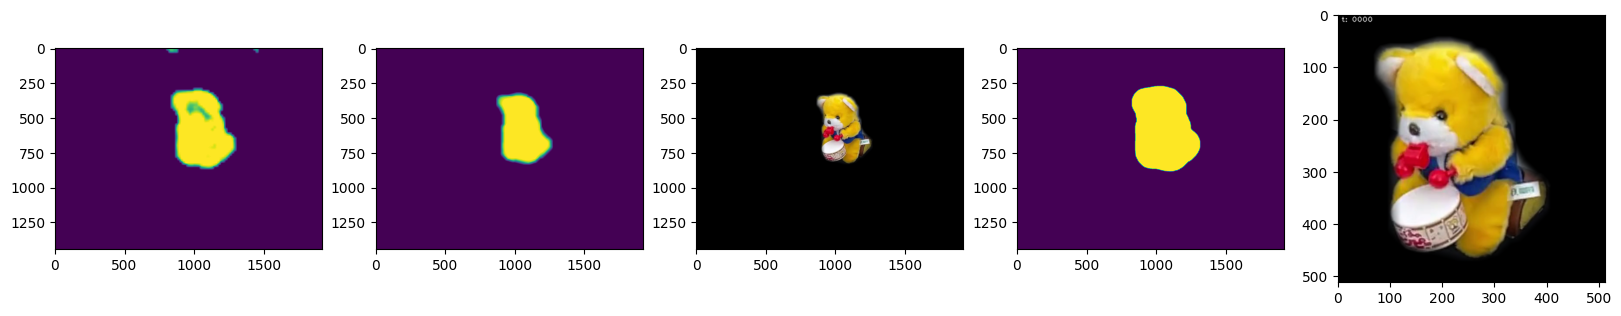

(907, 273, 1496, 862)


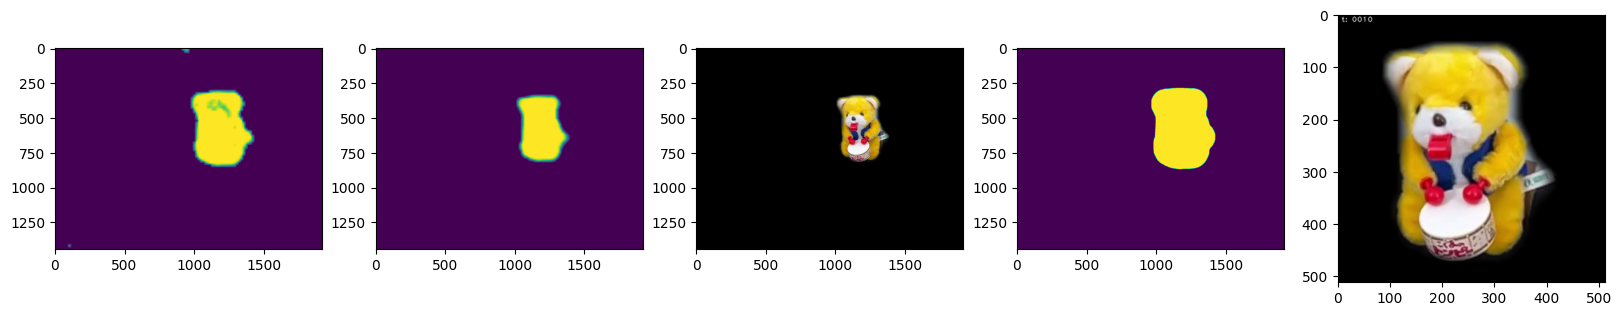

(682, 178, 1229, 725)


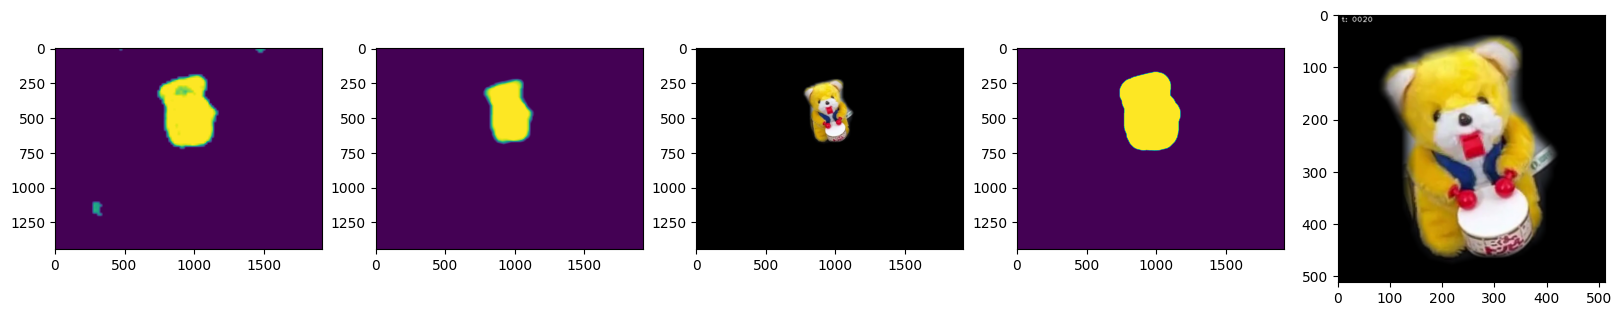

bad_indices: []


In [7]:
frames = []
views = []
bad_indices = []
size = 512
scale = 1.
sl = 0.04
index_prev = None
st, gt = 70, 91

for t, (index, real, pred, rvec, tvec) in enumerate(
    zip(tqdm(indices[st:gt]), main_real[st:gt], main_pred[st:gt], rvec_hist[st:gt], tvec_hist[st:gt])):

    real_orig = deepcopy(real)
    pred_orig = deepcopy(pred)
    real = deepcopy(real)
    pred = deepcopy(pred)

    R, _ = cv2.Rodrigues(rvec)
    T = tvec

    wpos_target = np.float32([[0,0,0.065]])
    cpos_target = project_w2c(wpos_target, rvec, tvec, mtx, dist).astype(np.int16)

    wpos_board = np.float32([[3.5,-2,0], [3.5,-7,0], [-3.5,-7,0], [-3.5,-2,0]]) * sl
    cpos_board = project_w2c(wpos_board, rvec, tvec, mtx, dist).astype(np.int32)

    wpos_camera = np.dot(R.T, - T).squeeze()
    wrot_camera = cv2.RQDecomp3x3(R.T)[0]
    _scale = np.sum(wpos_camera**2)**0.5 * scale
    
    if index_prev == index - 1:
        mask_aux = mask_aux
    else:
        mask_aux = None

    if not real.shape == pred.shape:        
        pred = cv2.resize(pred, real.shape[-2:-4:-1])

    ret, *out = warper(pred, real)
    if ret:
        pred, = out

        ret, *out = remover(real, pred, cpos_board, cpos_target, mask_aux)    
        if ret:
            segm, mask_aux, diff, alpha = out

            ret, *out = cropper(segm, cpos_target, size, _scale)
            if ret:
                crop, (x0, y0, x1, y1) = out

    if not ret:
        msg, = out
        bad_indices.append(index)
        print("skip (t={}, msg=\"{}\")".format(t, msg))

        # first failure in last some frames
        if index_prev == index - 1:
            plt.figure(figsize=(8,8))
            plt.subplot(1,2,1); plt.imshow(real_orig); plt.subplot(1,2,2); plt.imshow(pred_orig)
            plt.show()
        continue

    crop = cv2.putText(crop, "t: {:04}".format(t), 
                       (5, 15), cv2.FONT_HERSHEY_PLAIN, 
                       1, (255, 255, 255), 1, cv2.LINE_AA)

    view = np.concatenate([wpos_camera, wrot_camera])

    if t % 10 == 0:
        print((x0, y0, x1, y1))
        plt.figure(figsize=(20,20))
        plt.subplot(1,5,1); plt.imshow(diff)
        plt.subplot(1,5,2); plt.imshow(alpha)
        plt.subplot(1,5,3); plt.imshow(segm)
        plt.subplot(1,5,4); plt.imshow(mask_aux)
        plt.subplot(1,5,5); plt.imshow(crop)
        plt.show()

    views.append(view)
    frames.append(crop)
    index_prev = index

print("bad_indices:", bad_indices)
# imageio.mimwrite("temp/main_crop_000.mp4", frames, macro_block_size=8)

In [32]:
len(frames64), len(frames), len(views)

(592, 592, 592)

In [15]:
frames64 = [cv2.resize(frame, (64,64)) for frame in frames]

imageio.mimwrite("frames64.mp4", frames64, macro_block_size=8)
imageio.mimwrite("frames256.mp4", frames, macro_block_size=8)
np.save("views.npy", np.array(views))

In [41]:
!rm -rf data

In [42]:
import os
os.makedirs('data/train/video_large', exist_ok=True)
os.makedirs('data/train/video', exist_ok=True)
os.makedirs('data/train/view', exist_ok=True)
os.makedirs('data/test/video_large', exist_ok=True)
os.makedirs('data/test/video', exist_ok=True)
os.makedirs('data/test/view', exist_ok=True)

for i in range(0,50):
    imageio.mimwrite("data/train/video/frames64_{:03}.mp4".format(i), frames64[i*11:(i+1)*11], macro_block_size=8)
    imageio.mimwrite("data/train/video_large/frames256_{:03}.mp4".format(i), frames[i*11:(i+1)*11], macro_block_size=8)
    np.save("data/train/view/views_{:03}.npy".format(i), np.array(views[i*11:(i+1)*11]))

for i in range(48,52):
    imageio.mimwrite("data/test/video/frames64_{:03}.mp4".format(i), frames64[i*11:(i+1)*11], macro_block_size=8)
    imageio.mimwrite("data/test/video_large/frames256_{:03}.mp4".format(i), frames[i*11:(i+1)*11], macro_block_size=8)
    np.save("data/test/view/views_{:03}.npy".format(i), np.array(views[i*11:(i+1)*11]))

In [17]:
main_real = imageio.mimread("src/main_real.mp4", memtest=False)
main_pred = imageio.mimread("src/main_pred_d2.mp4", memtest=False)
main_segm = imageio.mimread("src/main_segm.mp4", memtest=False)
print(len(main_real), main_real[0].shape, len(main_pred), main_pred[0].shape, len(main_segm), main_segm[0].shape)

592 (1440, 1920, 3) 592 (720, 960, 3) 592 (1440, 1920, 3)


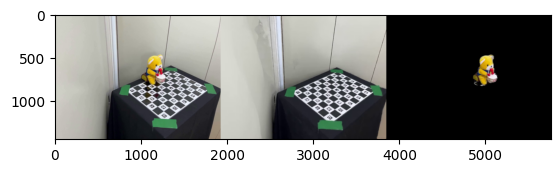

In [18]:
main_pred_ = [cv2.resize(im, (1920, 1440)) for im in main_pred]
main_real_ = np.array(main_real)
main_pred_ = np.array(main_pred_)
main_segm_ = np.array(main_segm)
main_concat = np.concatenate([main_real_, main_pred_, main_segm_], axis=2)
plt.imshow(main_concat[0])
imageio.mimwrite("src/main_concat3.mp4", main_concat, macro_block_size=8, fps=30)

In [11]:
main_segm = imageio.mimread("src/main_segm.mp4", memtest=False)
print(len(main_segm), main_segm[0].shape)

100 (1440, 1920, 3)


In [1]:
import cv2
import cv2.aruco as aruco
import imageio
import numpy as np
import matplotlib.pyplot as plt
import imageio
from copy import deepcopy
from tqdm.notebook import tqdm


main_real = imageio.mimread("temp/main_real_000.mp4", memtest=False)
main_pred = imageio.mimread("temp/main_pred_000.mp4", memtest=False)
print(len(main_real), main_real[0].shape, len(main_pred), main_pred[0].shape)

623 (1440, 1920, 3) 623 (720, 960, 3)


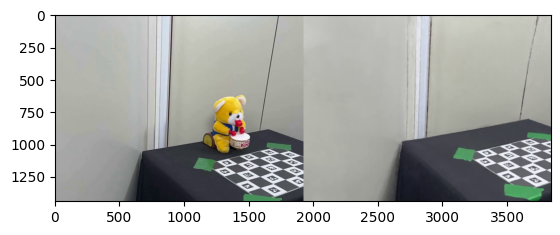

In [3]:
main_pred_ = [cv2.resize(im, (1920, 1440)) for im in main_pred]
main_real_ = np.array(main_real)
main_pred_ = np.array(main_pred_)
main_concat = np.concatenate([main_real_, main_pred_], axis=2)
plt.imshow(main_concat[0])
imageio.mimwrite("main_concat2_000.mp4", main_concat, macro_block_size=8, fps=10)

In [ ]:
# torchnerf
def generate_rays(c2w, w, h, fx, fy):
    x, y = np.meshgrid(
        np.arange(w, dtype=np.float32) + 0.5,
        np.arange(h, dtype=np.float32) + 0.5,
        indexing="xy",
    )

    camera_dirs = np.stack(
        [
            (x - w * 0.5) / fx,
            -(y - h * 0.5) / fy,
            -np.ones_like(x),
        ],
        axis=-1,
    )

    _c2w = camtoworlds[None, None, :3, :3]
    camera_dirs = camera_dirs[Ellipsis, None]
    directions = np.matmul(_c2w, camera_dirs)[Ellipsis, 0]
    origins = np.broadcast_to(
        camtoworlds[None, None, :3, -1], directions.shape
    )
    norms = np.linalg.norm(directions, axis=-1, keepdims=True)
    viewdirs = directions / norms
    return origins, directions, viewdirs